In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense,MaxPool2D,Dropout,Flatten,Conv2D,GlobalAveragePooling2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
 
from random import choice,shuffle
from scipy import stats as st
 
from collections import deque

In [2]:
def gather_data(num_samples):
     
    global rock, paper, scissor, nothing
     
    # Initialize the camera
    cap = cv2.VideoCapture(0)
 
    # trigger tells us when to start recording
    trigger = False
     
    # Counter keeps count of the number of samples collected
    counter = 0
     
    # This the ROI size, the size of images saved will be box_size -10
    box_size = 234
     
    # Getting the width of the frame from the camera properties
    width = int(cap.get(3))
 
 
    while True:
         
        # Read frame by frame
        ret, frame = cap.read()
         
        # Flip the frame laterally
        frame = cv2.flip(frame, 1)
         
        # Break the loop if there is trouble reading the frame.
        if not ret:
            break
             
        # If counter is equal to the number samples then reset triger and the counter
        if counter == num_samples:
            trigger = not trigger
            counter = 0
         
        # Define ROI for capturing samples
        cv2.rectangle(frame, (width - box_size, 0), (width, box_size), (0, 250, 150), 2)
         
        # Make a resizable window.
        cv2.namedWindow("Collecting images", cv2.WINDOW_NORMAL)
         
         
        # If trigger is True than start capturing the samples
        if trigger:
             
            # Grab only slected roi
            roi = frame[5: box_size-5 , width-box_size + 5: width -5]
             
            # Append the roi and class name to the list with the selected class_name
            eval(class_name).append([roi, class_name])
                                     
            # Increment the counter 
            counter += 1
         
            # Text for the counter
            text = "Collected Samples of {}: {}".format(class_name, counter)
             
        else:
            text = "Press 'r' to collect rock samples, 'p' for paper, 's' for scissor and 'n' for nothing"
         
        # Show the counter on the imaege
        cv2.putText(frame, text, (3, 350), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 1, cv2.LINE_AA)
         
        # Display the window
        cv2.imshow("Collecting images", frame)
         
        # Wait 1 ms
        k = cv2.waitKey(1)
         
        # If user press 'r' than set the path for rock directoryq
        if k == ord('r'):
             
            # Trigger the variable inorder to capture the samples
            trigger = not trigger
            class_name = 'rock'
            rock = []
            
             
        # If user press 'p' then class_name is set to paper and trigger set to True  
        if k == ord('p'):
            trigger = not trigger
            class_name = 'paper'
            paper = []
         
        # If user press 's' then class_name is set to scissor and trigger set to True  
        if k == ord('s'):
            trigger = not trigger
            class_name = 'scissor'
            scissor = []
            # If user press 's' then class_name is set to nothing and trigger set to True
        if k == ord('n'):
            trigger = not trigger
            class_name = 'nothing'
            nothing = []
         
        # Exit if user presses 'q'
        if k == ord('q'):
            break
             
    #  Release the camera and destroy the window
    cap.release()
    cv2.destroyAllWindows()

In [3]:
no_of_samples = 100
gather_data(no_of_samples)


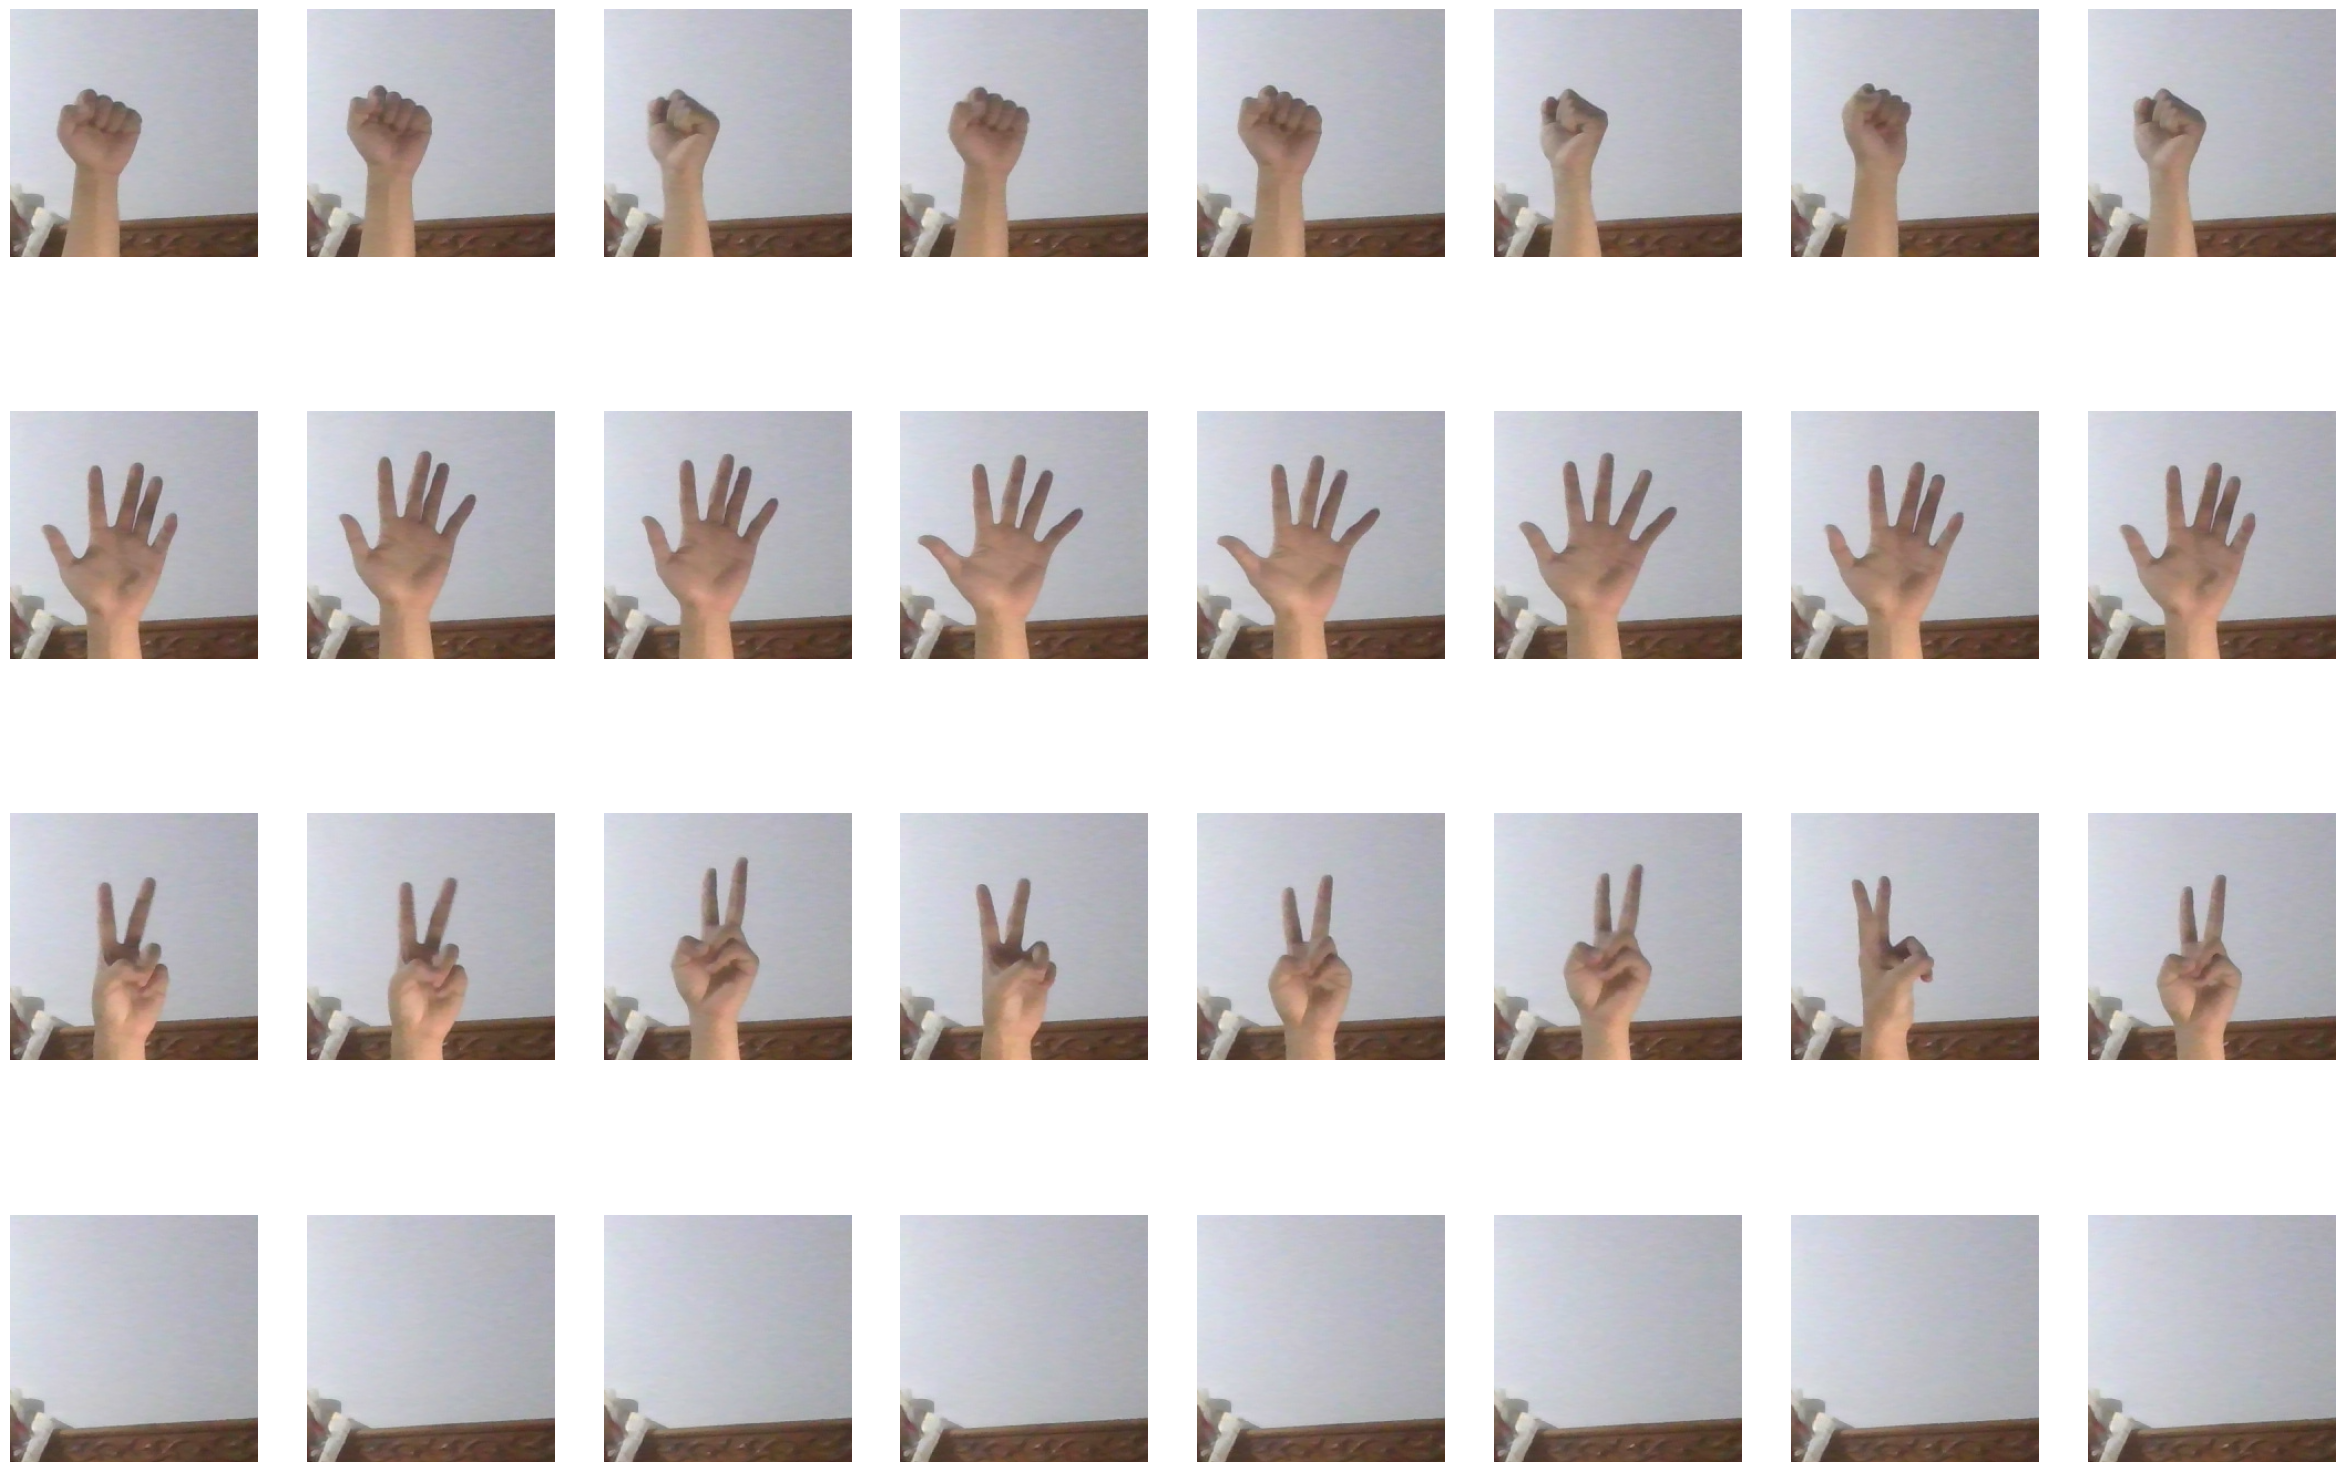

In [4]:
plt.figure(figsize=[30,20])
 
# Set the rows and columns
rows, cols = 4, 8
 
# Iterate for each class
for class_index, each_list in enumerate([rock, paper, scissor,nothing]):
     
    # Get 8 random indexes, since we will be showing 8 examples of each class.
    r = np.random.randint(no_of_samples, size=8);
     
    # Plot the examples
    for i, example_index in enumerate(r,1):
        plt.subplot(rows,cols,class_index*cols + i );plt.imshow(each_list[example_index][0][:,:,::-1]);plt.axis('off');

In [5]:
labels = [tupl[1] for tupl in rock] + [tupl[1] for tupl in paper] + [tupl[1] for tupl in scissor] +[tupl[1] for tupl in nothing]
 
# Combine the images of all classes together
images = [tupl[0] for tupl in rock] + [tupl[0] for tupl in paper] + [tupl[0] for tupl in scissor] +[tupl[0] for tupl in nothing]
 
# Normalize the images by dividing by 255, now our images are in range 0-1. This will help in training.
images = np.array(images, dtype="float") / 255.0
 
# Print out the total number of labels and images.
print('Total images: {} , Total Labels: {}'.format(len(labels), len(images)))
 
# Create an encoder Object
encoder = LabelEncoder()
 
# Convert Lablels to integers. i.e. nothing = 0, paper = 1, rock = 2, scissor = 3 (mapping is done in alphabatical order)
Int_labels = encoder.fit_transform(labels)
 
# Now the convert the integer labels into one hot format. i.e. 0 = [1,0,0,0]  etc.
one_hot_labels = to_categorical(Int_labels, 4)
 
# Now we're splitting the data, 75% for training and 25% for testing.
(trainX, testX, trainY, testY) = train_test_split(images, one_hot_labels, test_size=0.25, random_state=50)
 
# Empty memory from RAM
images = []


Total images: 400 , Total Labels: 400


In [6]:
image_size = 224
 
# Loading pre-trained NASNETMobile Model without the head by doing include_top = False
N_mobile = tf.keras.applications.NASNetMobile( input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet')
 
# Freeze the whole model 
N_mobile.trainable = False
     
# Adding our own custom head
# Start by taking the output feature maps from NASNETMobile
x = N_mobile.output
 
# Convert to a single-dimensional vector by Global Average Pooling. 
# We could also use Flatten()(x) GAP is more effective reduces params and controls overfitting.
x = GlobalAveragePooling2D()(x)
 
# Adding a dense layer with 712 units
x = Dense(712, activation='relu')(x) 
 
# Dropout 40% of the activations, helps reduces overfitting
x = Dropout(0.40)(x)
 
# The fianl layer will contain 4 output units (no of units = no of classes) with softmax function.
preds = Dense(4,activation='softmax')(x) 
 
# Construct the full model
model = Model(inputs=N_mobile.input, outputs=preds)
 
# Check the number of layers in the final Model
print ("Number of Layers in Model: {}".format(len(model.layers[:])))


Number of Layers in Model: 773


In [7]:
augment = ImageDataGenerator( 
     
        rotation_range=30,
        zoom_range=0.25,
        width_shift_range=0.10,
        height_shift_range=0.10,
        shear_range=0.10,
        horizontal_flip=False,
        fill_mode="nearest"
)
	
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
epochs = 15
batchsize = 20
 
# Start training
history = model.fit(x=augment.flow(trainX, trainY, batch_size=batchsize), validation_data=(testX, testY), 
steps_per_epoch= len(trainX) // batchsize, epochs=epochs)

c:\Users\vohoa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 35s 988ms/step - accuracy: 0.4129 - loss: 1.2968 - val_accuracy: 0.8800 - val_loss: 0.5728
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 477ms/step - accuracy: 0.8725 - loss: 0.5169 - val_accuracy: 0.9500 - val_loss: 0.2326
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 462ms/step - accuracy: 0.9311 - loss: 0.2845 - val_accuracy: 0.9600 - val_loss: 0.1373
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 500ms/step - accuracy: 0.9646 - loss: 0.1876 - val_accuracy: 0.9600 - val_loss: 0.0895
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 512ms/step - accuracy: 0.9746 - loss: 0.1373 - val_accuracy: 0.9600 - val_loss: 0.0776
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 480ms/step - accuracy: 0.9952 - loss: 0.0666 - val_accuracy: 1.0000 - val_loss: 0.0491
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 467ms/step - accuracy: 0.9951 - loss: 0.0674 - val_accuracy: 1.0000 - val_loss: 0.0439
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 493ms/step - accuracy: 0.9991 - loss: 0.0704 - val_accuracy: 1

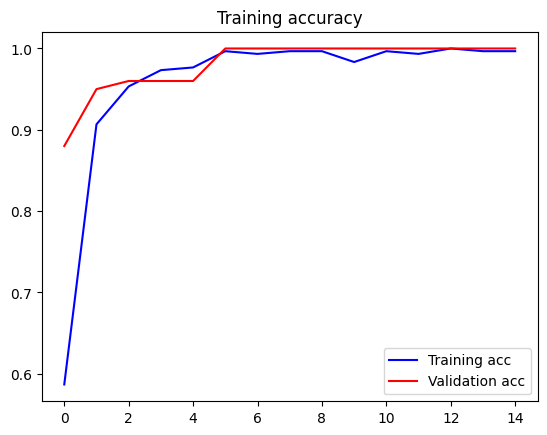

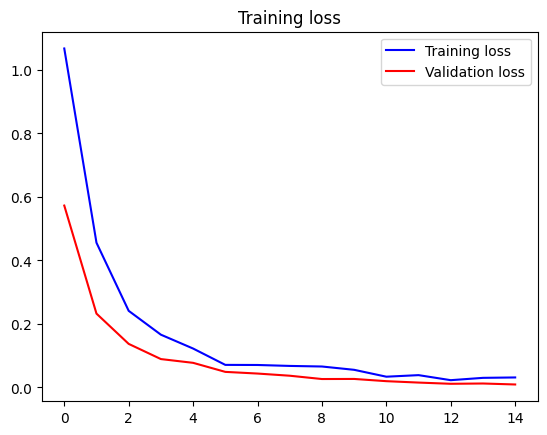

In [9]:
# Plot the accuracy and loss curves
 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training loss')
plt.legend()
 
plt.show()

In [10]:
model.save("rps1.h5")
model = load_model("rps1.h5")


In [11]:
def findout_winner(user_move, Computer_move):
     
    # All logic below is self explanatory 
     
    if user_move == Computer_move:
        return "Tie"   
     
    elif user_move == "rock" and Computer_move == "scissor":
        return "User"
     
    elif user_move == "rock" and Computer_move == "paper":
        return "Computer"
     
    elif user_move == "scissor" and Computer_move == "rock":
        return "Computer"
     
    elif user_move == "scissor" and Computer_move == "paper":
        return "User"
     
    elif user_move == "paper" and Computer_move == "rock":
        return "User"
     
    elif user_move == "paper" and Computer_move == "scissor":
        return "Computer"

In [12]:
user_move = 'paper'
computer_move = choice(['rock', 'paper', 'scissor'])
 
winner = findout_winner(user_move, computer_move)
 
print("User Selected '{}' and computer selected '{}' , winner is: '{}' ".format(user_move, computer_move, winner))

User Selected 'paper' and computer selected 'paper' , winner is: 'Tie' 


In [13]:
user_move = 'paper'
computer_move = choice(['rock', 'paper', 'scissor'])
 
winner = findout_winner(user_move, computer_move)
 
print("User Selected '{}' and computer selected '{}' , winner is: '{}' ".format(user_move, computer_move, winner))

User Selected 'paper' and computer selected 'paper' , winner is: 'Tie' 


In [14]:
def show_winner(user_score, computer_score):    
     
    if user_score > computer_score:
        img = cv2.imread("images/youwin.jpg")
         
    elif user_score < computer_score:
        img = cv2.imread("images/comwins.jpg")
         
    else:
        img = cv2.imread("images/draw.jpg")
         
    cv2.putText(img, "Press 'ENTER' to play again, else exit",
                (150, 530), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 3, cv2.LINE_AA)
     
    cv2.imshow("Rock Paper Scissors", img)
     
    # If enter is pressed.
    k = cv2.waitKey(0)
     
    # If the user presses 'ENTER' key then return TRUE, otherwise FALSE
    if k == 13:
       return True
 
    else:
        return False

In [15]:
def display_computer_move(computer_move_name, frame):
     
    icon = cv2.imread( "images/{}.png".format(computer_move_name), 1)
    icon = cv2.resize(icon, (224,224))
     
    # This is the portion which we are going to replace with the icon image
    roi = frame[0:224, 0:224]
 
    # Get binary mask from the transparent image, 4th channel is the alpha channel 
    mask = icon[:,:,-1] 
 
    # Making the mask completely binary (black & white)
    mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)[1]
 
    # Store the normal bgr image
    icon_bgr = icon[:,:,:3] 
     
    # Now combine the foreground of the icon with background of ROI 
     
    img1_bg = cv2.bitwise_and(roi, roi, mask = cv2.bitwise_not(mask))
 
    img2_fg = cv2.bitwise_and(icon_bgr, icon_bgr, mask = mask)
 
    combined = cv2.add(img1_bg, img2_fg)
 
    frame[0:224, 0:224] = combined
 
    return frame

In [17]:
import cv2
import numpy as np
import statistics as st
from collections import deque
from random import choice

# Hàm xác định người thắng cuộc
def findout_winner(user_move, computer_move):
    if user_move == computer_move:
        return "Tie"
    if (user_move == "rock" and computer_move == "scissor") or \
       (user_move == "paper" and computer_move == "rock") or \
       (user_move == "scissor" and computer_move == "paper"):
        return "User"
    return "Computer"

# Hàm hiển thị nước đi của máy tính
def display_computer_move(move, frame):
    text = f"Computer chose: {move}"
    cv2.putText(frame, text, (100, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)

# Hàm hiển thị kết quả và hỏi người chơi có muốn chơi lại không

def show_winner(user_score, computer_score):
    print(f"User Score: {user_score}, Computer Score: {computer_score}")
    if user_score > computer_score:
        print("🎉 Bạn thắng!")
    elif user_score < computer_score:
        print("😞 Máy thắng!")
    else:
        print("🤝 Hòa!")
    
    play_again = input("Chơi lại không? (y/n): ").strip().lower()
    return play_again == 'y'

# Mở webcam
cap = cv2.VideoCapture(0)
box_size = 234
width = int(cap.get(3))

# Thiết lập số lần chơi
attempts = 5
total_attempts = attempts

# Biến lưu kết quả
computer_move_name = "nothing"
final_user_move = "nothing"
label_names = ['nothing', 'paper', 'rock', 'scissor']
computer_score, user_score = 0, 0
rect_color = (255, 0, 0)
hand_inside = False
confidence_threshold = 0.70
smooth_factor = 5
de = deque(['nothing'] * 5, maxlen=smooth_factor)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)
    cv2.namedWindow("Rock Paper Scissors", cv2.WINDOW_NORMAL)

    # Xác định vùng tay
    roi = frame[5: box_size-5, width-box_size + 5: width - 5]
    roi = np.array([roi]).astype('float64') / 255.0

    # Mô hình dự đoán
    pred = model.predict(roi)  # <--- Đảm bảo đã load mô hình trước đó
    move_code = np.argmax(pred[0])
    user_move = label_names[move_code]
    prob = np.max(pred[0])

    # Nếu xác suất đủ cao, cập nhật kết quả
    if prob >= confidence_threshold:
        de.appendleft(user_move)
        final_user_move = max(set(de), key=de.count)  # Sử dụng mode() thủ công

        if final_user_move != "nothing" and not hand_inside:
            hand_inside = True
            computer_move_name = choice(['rock', 'paper', 'scissor'])
            winner = findout_winner(final_user_move, computer_move_name)
            display_computer_move(computer_move_name, frame)
            total_attempts -= 1

            if winner == "Computer":
                computer_score += 1
                rect_color = (0, 0, 255)
            elif winner == "User":
                user_score += 1
                rect_color = (0, 255, 0)
            else:
                rect_color = (255, 255, 255)

            # Nếu hết lượt, hỏi người chơi có muốn tiếp tục không
            if total_attempts == 0:
                play_again = show_winner(user_score, computer_score)
                if play_again:
                    user_score, computer_score, total_attempts = 0, 0, attempts
                else:
                    break

        elif final_user_move != "nothing":
            display_computer_move(computer_move_name, frame)
        else:
            hand_inside = False
            rect_color = (255, 0, 0)

    # Hiển thị điểm số
    cv2.putText(frame, f"Your Move: {final_user_move}", (420, 270), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
    cv2.putText(frame, f"Computer's Move: {computer_move_name}", (2, 270), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
    cv2.putText(frame, f"Your Score: {user_score}", (420, 300), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
    cv2.putText(frame, f"Computer Score: {computer_score}", (2, 300), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
    cv2.putText(frame, f"Attempts left: {total_attempts}", (190, 400), 
                cv2.FONT_HERSHEY_COMPLEX, 0.7, (100, 2, 255), 1)
    
    cv2.rectangle(frame, (width - box_size, 0), (width, box_size), rect_color, 2)
    cv2.imshow("Rock Paper Scissors", frame)

    # Thoát nếu nhấn 'q'
    if cv2.waitKey(10) == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━